In [1]:
library("knitr")
library("glmnet")
library("ggplot2")
library("tidyverse")
library("data.table")

knitr::opts_chunk$set(echo = TRUE)

Loading required package: Matrix

Loaded glmnet 4.1-1

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Reading the data

For this practical session on logistic regression we are using a dataset on the relationship between cleft lip in dogs (Nova Scotia Duck Tolling Retriever, NSDTR) and SNP genotypes ([data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.j8r8q); [paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005059)).

The public dataset downloaded from Dryad is a *Plink* `.tped/.tfam` file. The data have been preprocessed:

- filtered (SNP quality, call-rate, MAF)
- imputed (imputation of missing genotypes using LHCI: localised haplotype-clustering imputation)
- selected (only SNPs on chromosomes 25, 26, 27, 28, 29)

In [2]:
dogs <- fread("../data/dogs_imputed.raw")
dogs <- dogs %>%
  select(-c(IID,FID,PAT,MAT,SEX))

dogs$PHENOTYPE = dogs$PHENOTYPE-1
nsnps = ncol(dogs)-1
print(paste("N. SNPs (features):",nsnps))
table(dogs$PHENOTYPE)

[1] "N. SNPs (features): 5488"



  0   1 
112  13 

In [3]:
maf_controls <- colSums(dogs[dogs$PHENOTYPE==0,-c(1,2)])/(2*nrow(dogs[dogs$PHENOTYPE==0,]))
maf_cases <- colSums(dogs[dogs$PHENOTYPE==1,-c(1,2)])/(2*nrow(dogs[dogs$PHENOTYPE==1,]))

No id variables; using all as measure variables



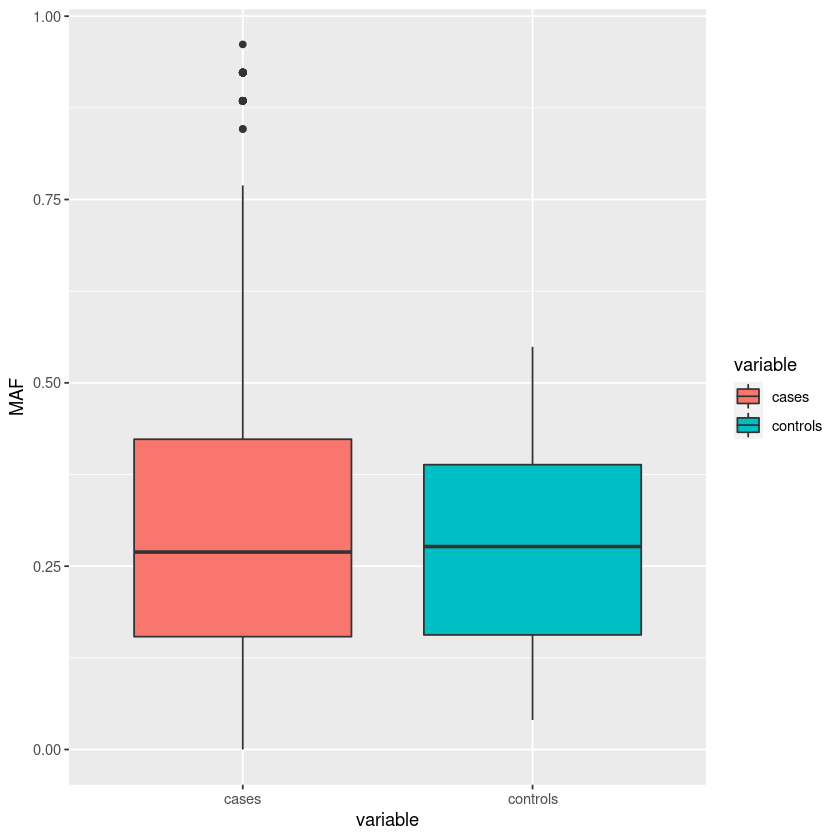

In [4]:
maf <- data.frame("cases"=maf_cases, "controls"=maf_controls)
mD <- reshape2::melt(maf)
ggplot(mD, aes(y = value, x = variable)) + geom_boxplot(aes(fill=variable)) + ylab("MAF")

## Fitting the Lasso-penalised logistic regression model

We have **`r nrow(dogs)`** records (sample size) and **`r ncol(dogs)-1`** SNP markers: this is a $p > n$ problem, and **regularization** is therefore needed.

First, we fit the Lasso-penalised logistic regression model to the entire dataset, to illustrate some properties of Lasso (L1) regularization:

In [7]:
print(nrow(dogs))
print(ncol(dogs)-1)

[1] 125
[1] 5488


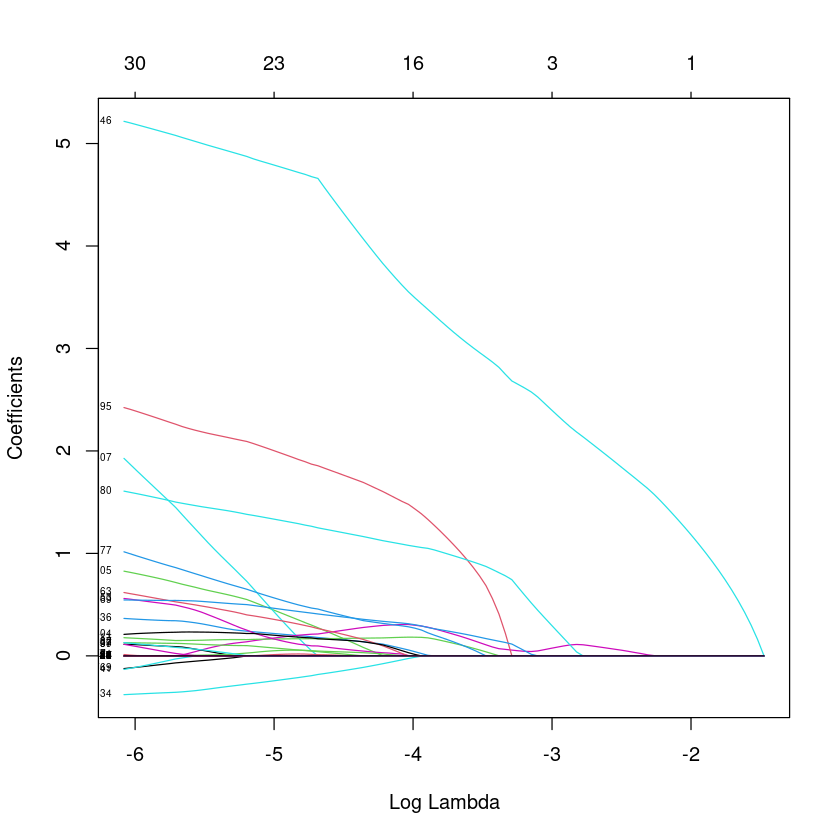

In [8]:
x <- as.matrix(dogs[,-1])
y <- as.factor(dogs$PHENOTYPE)

fit.lasso <- glmnet(x, y, alpha = 1, family = "binomial")
plot(fit.lasso, xvar="lambda", label=TRUE)

In [10]:
summary(fit.lasso$lambda)
tmp_coeffs <- coef(fit.lasso, s = exp(-4))
df <- data.frame(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], coefficient = tmp_coeffs@x)
df

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002288 0.007238 0.022889 0.049865 0.072376 0.228826 

name,coefficient
<chr>,<dbl>
(Intercept),-6.629160e+00
chr27.8866968_T,4.559740e-02
chr27.13664811_A,3.510899e+00
chr27.14430418_A,3.012096e-01
chr27.32729820_G,1.446691e+00
chr27.41939632_A,1.822994e-01
chr27.42003822_G,2.676947e-14
chr28.4533790_C,-1.707788e-02
chr28.4562192_A,-1.349044e-04


In practice, we would begin by setting aside a test set (stratified, as we did previously):

In [11]:
seed = 17
set.seed(seed)
n = nrow(dogs) ## sample size

dogs$id <- paste("id",seq(1,nrow(dogs)), sep="_")

training_set <- dogs %>%
  group_by(PHENOTYPE) %>%
  sample_frac(size = 0.75)

test_recs <- !(dogs$id %in% training_set$id)
test_set <- dogs[test_recs,]

training_set$id <- NULL
test_set$id <- NULL

x_train <- as.matrix(training_set[,-1])
y_train <- as.factor(training_set$PHENOTYPE)
x_test <- as.matrix(test_set[,-1])
y_test <- as.factor(test_set$PHENOTYPE)

table(y_train)
table(y_test)

y_train
 0  1 
84 10 

y_test
 0  1 
28  3 

We then apply k-fold cross-validation to select the best value for the regularization parameter $\lambda$ (*model tuning*)

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


[1] 0.0782543

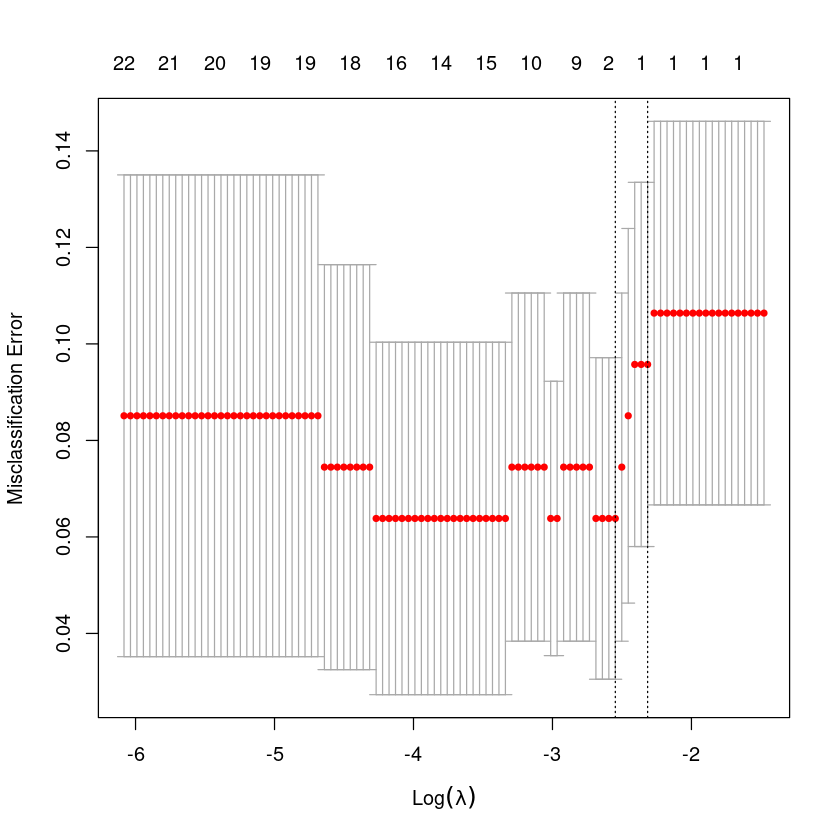

In [12]:
cv.lasso <- cv.glmnet(x_train, y_train, family = "binomial", type.measure = "class", nfolds = 10, alpha = 1)
plot(cv.lasso)
cv.lasso$lambda.min
# coef(cv.lasso, s = "lambda.min")

The tuned value for the $\lambda$ parameter is `r cv.lasso$lambda.min`

### Fit the final model on the training data

We can now fit the final model (tuned with cross-validarion) to the training set:

In [15]:
model <- glmnet(x_train, y_train, alpha = 1, family = "binomial", lambda = cv.lasso$lambda.min)
# plot(model,xvar="lambda",label=TRUE)
tmp_coeffs <- coef(model)
df <- data.frame(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], coefficient = tmp_coeffs@x)

### Make predictions

With the solutions from the trained model, we can now make predictions:

In [10]:
probs <- predict(model, newx = x_test, type = "response")
predictions <- ifelse(probs > 0.5, 1, 0)
table(predictions, y_test)

           y_test
predictions  0  1
          0 28  0
          1  0  3

ROC curves can help us evaluate different classifiers (e.g. logistic regression vs Lasso-penalised logistic regression) over all possible decision thresholds:

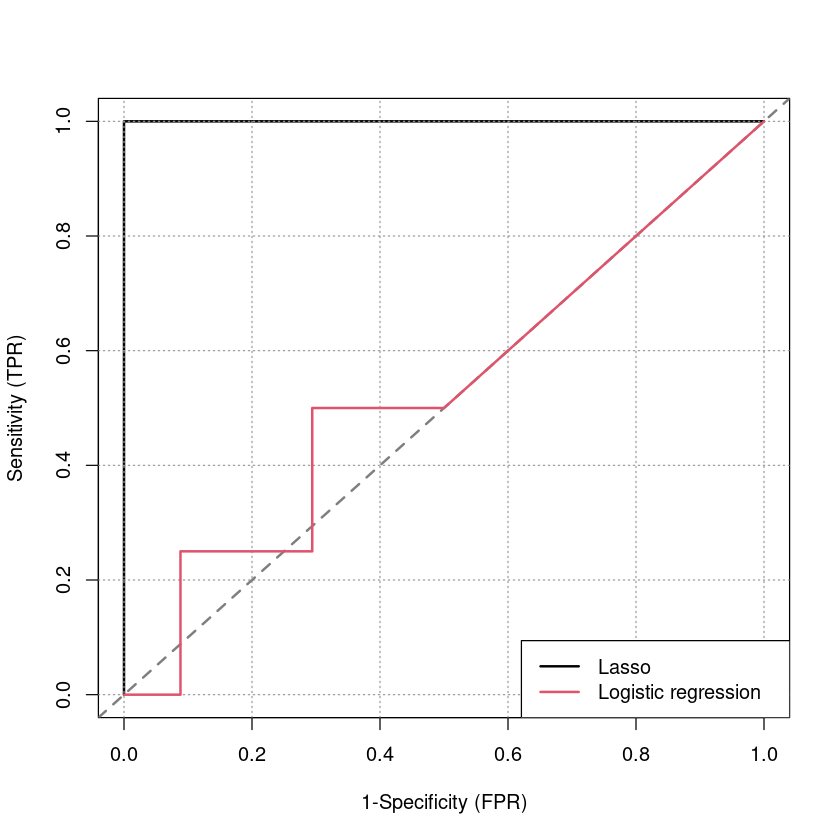

In [11]:
library("ROCit")

load("ROClogit.RData")

ROCit_lasso <- rocit(score=probs[,1],class=y_test)
plot(ROCit_lasso, col = c(1,"gray50"), 
     legend = FALSE, YIndex = FALSE)
lines(ROCit_logit$TPR~ROCit_logit$FPR,col = 2, lwd = 2)
legend("bottomright", col = c(1,2),
       c("Lasso", "Logistic regression"), lwd = 2)

save(ROCit_lasso, file = "ROClasso.RData")